# Probabilistic Time Series Analysis

## Week 10: Sparse Gaussian Processes Methods

Places where you are supposed to fill in code are marked

    #
    # TODO: some instructions
    # 
    
The rest of the code we will run and discuss if time permits, otherwise try it out at home and try to answer the questions mentioned in the text boxes for yourself.

### Please turn in the code before 12/5/2018 5:20pm. 

### Your work will be evaluated based on the code and plots. You don't need to write down your answers to other questions in the text blocks, just think them over.

### Title your submission file `lab10-student-[YOUR NET ID].ipynb`.

# Setup

In [3]:
import numpy as np
import GPy
import time
import matplotlib.pyplot as plt

%matplotlib inline

# I. Pseudo-Dataset Size Requirement

In [4]:
def uniform_samples(x_min, x_max, n_samples, f, noise_scale):
    """Generates f(x) + noise for x uniformly distributed in [x_min, x_max]."""
    X = np.random.uniform(x_min, x_max, size=(n_samples, 1))
    Y = f(X) + np.random.normal(scale=noise_scale, size=(n_samples, 1))
    return X, Y

def gapped_samples(x_min, x_max, n_samples, f, noise_scale):
    """Generates f(x) + noise for x uniformly distributed in [x_min, x_max] missing middle third."""
    X = np.array(
        list(np.random.uniform(x_min, x_min + (x_max - x_min) / 3.0, size=(n_samples / 2, 1))) + 
        list(np.random.uniform(x_min + 2.0 * (x_max - x_min) / 3.0, x_max, size=(n_samples / 2, 1))))
    Y = f(X) + np.random.normal(scale=noise_scale, size=(n_samples, 1))
    return X, Y

In [5]:
X, Y = uniform_samples(-20.0, 20.0, 100, np.sin, 0.05)

In [6]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

As a reminder, here is an example of "naive" GP regression, as we studied in the last lab:

 /home/marina/.pyenv/versions/3.6.6/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


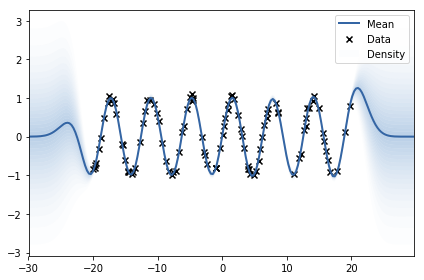

In [5]:
m_reg = GPy.models.GPRegression(X, Y, kernel)
_ = m_reg.optimize()
_ = m_reg.plot(plot_density=True)

And here is an example of FITC regression, where the `num_inducing` parameter controls how many points are used in the pseudo-dataset.

In [6]:
from timeit import default_timer as timer

64.67 seconds


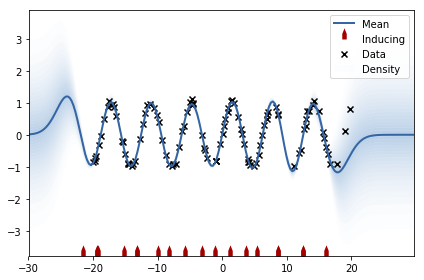

In [8]:
# similar to naive (though the on the extremes they differ a lot - because not so many points there). 
# 20 is enough
start = timer()

m_sparse = GPy.models.SparseGPRegression(X, Y, kernel, num_inducing=20)
m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
_ = m_sparse.optimize()
_ = m_sparse.plot(plot_density=True)

end = timer()
print(round(end - start, 2) , 'seconds')

0.91 seconds


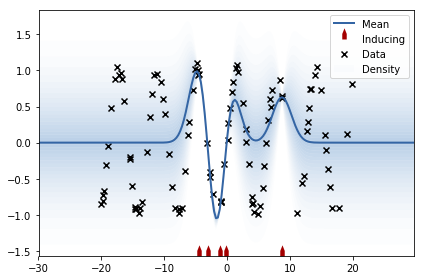

In [9]:
# not enough 
start = timer()

m_sparse = GPy.models.SparseGPRegression(X, Y, kernel, num_inducing=5)
m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
_ = m_sparse.optimize()
_ = m_sparse.plot(plot_density=True)

end = timer()
print(round(end - start, 2) , 'seconds')

In [ ]:
#
# TODO: Try varying num_inducing in the example above to identify how many samples are needed before the quality
# of the fit with FITC is similar to that with the naive method. Show one plot where there are still not enough
# pseudo-data points, and one where the results are similar.
#

In [11]:
test_X = np.linspace(-20.0, 20.0, 400).reshape(400, 1)

def model_distance(model_ref, model_test):
    ref_out = model_ref.predict(test_X)[0]
    test_out = model_test.predict(test_X)[0]
    return np.sum((ref_out - test_out) ** 2) / np.sum(ref_out ** 2)

print(model_distance(m_reg, m_sparse))

0.931229357564


In [ ]:
#
# TODO: Let's make the above result a little more quantitative. The function model_distance gives a numerical relative
# difference (in L^2 norm) between the outputs of two models. Make a plot of this number vs. the pseudo-dataset size 
# for a reasonable range of sizes.
# 

In [39]:
values = [1, 5, 7, 10, 12, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 100]
distances = []
k = 3
for i, value in enumerate(values):
    print('Ready: %i%%' % round(i / len(values) * 100, 1))
    sum_dist = 0
    for j in range(k):
        m_sparse = GPy.models.SparseGPRegression(X, Y, kernel, num_inducing=value)
        m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
        _ = m_sparse.optimize()
        sum_dist += model_distance(m_reg, m_sparse)
    distances.append(sum_dist / k)

Ready: 0%
Ready: 6%
Ready: 12%
Ready: 18%
Ready: 25%
Ready: 31%
Ready: 37%
Ready: 43%
Ready: 50%
Ready: 56%
Ready: 62%
Ready: 68%
Ready: 75%
Ready: 81%
Ready: 87%
Ready: 93%


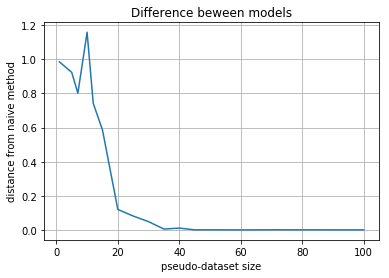

In [41]:
plt.plot(values, distances)
plt.title('Difference beween models')
plt.ylabel('distance from naive method')
plt.xlabel('pseudo-dataset size')
plt.grid()
plt.show()

# II. Efficiency Comparison

Here is a simple way to measure how long a piece of Python code takes:

In [7]:
X, Y = uniform_samples(-20.0, 20.0, 1000, np.sin, 0.05)

In [8]:
start = time.time()
m_reg = GPy.models.GPRegression(X, Y, kernel)
_ = m_reg.optimize()
end = time.time()
print('Naive method:', end - start, 'seconds')

start = time.time()
m_sparse = GPy.models.SparseGPRegression(X, Y, kernel, num_inducing=10)
m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
_ = m_sparse.optimize()
end = time.time()
print('Sparse method:', end - start, 'seconds')

Naive method: 4.509270191192627 seconds
Sparse method: 3.973550319671631 seconds


As you can see, we weren't lying to you---the sparse method is much faster. But how much? Let's investigate the runtime asymptotics we claimed in class.

There are two relevant numbers: $N$ is the number of data points in the original set, $N = 1000$ above, and $M$ is the number of pseudo-datapoints we use, $M = 10$ above. The naive method is supposed to run in time $O(N^3)$, while the FITC method is supposed to run in time $O(NM^2)$.

In [ ]:
#
# TODO: Study the dependence of the runtimes of the two methods on N: fix some reasonable M, vary N, for each N 
# drawing several sets of samples as above, and measure how long it takes to optimize each of the two models. For each
# N and each model, take the mean of the times you measure, and plot these. If you want, try to confirm the power
# scaling on a log-log plot. (Timing studies are hard and this is a very naive way to measure code execution, so don't
# worry if it doesn't look perfect.)
#

In [13]:
M = 10
range_N = [i for i in range(500, 5000, 1000)]
times_naive = []
times_sparse = []
k = 5

for i, N in enumerate(range_N):
    print('Ready: %i%%' % round(i / len(range_N) * 100, 1))
    
    sum_times_naive = 0
    sum_times_sparse = 0
    
    for j in range(k):
        X, Y = uniform_samples(-20.0, 20.0, N, np.sin, 0.05)
        
        start = time.time()
        m_reg = GPy.models.GPRegression(X, Y, kernel)
        _ = m_reg.optimize()
        end = time.time()
        t = end - start
        sum_times_naive += t

        start = time.time()
        m_sparse = GPy.models.SparseGPRegression(X, Y, kernel, num_inducing=M)
        m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
        _ = m_sparse.optimize()
        end = time.time()
        t = end - start
        sum_times_sparse += t
        
    times_naive.append(sum_times_naive / k)
    times_sparse.append(sum_times_sparse / k)

Ready: 0%
Ready: 20%
Ready: 40%
Ready: 60%


 /home/marina/.pyenv/versions/3.6.6/envs/py36/lib/python3.6/site-packages/GPy/inference/latent_function_inference/fitc.py:67: RuntimeWarning:overflow encountered in square
 /home/marina/.pyenv/versions/3.6.6/envs/py36/lib/python3.6/site-packages/GPy/inference/latent_function_inference/fitc.py:74: RuntimeWarning:invalid value encountered in multiply
 /home/marina/.pyenv/versions/3.6.6/envs/py36/lib/python3.6/site-packages/GPy/inference/latent_function_inference/fitc.py:80: RuntimeWarning:invalid value encountered in multiply


Ready: 80%


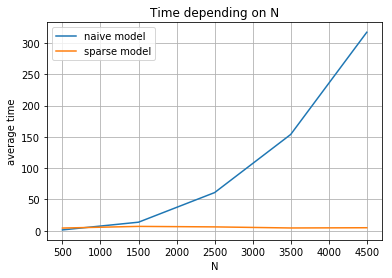

In [14]:
plt.plot(range_N, times_naive, label='naive model')
plt.plot(range_N, times_sparse, label='sparse model')
plt.title('Time depending on N')
plt.ylabel('average time')
plt.xlabel('N')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#
# TODO: Just for the FITC method, study the dependence of the runtime on M: fix some reasonable N, vary M, and proceed
# as above.
#

In [17]:
range_M = [i for i in range(10, 500, 50)]
N = 1000
times_vary_M = []
k = 5

for i, M in enumerate(range_M):
    print('Ready: %i%%' % round(i / len(range_M) * 100, 1))
    
    sum_times_sparse = 0
    
    for j in range(k):
        X, Y = uniform_samples(-20.0, 20.0, N, np.sin, 0.05)
        
        start = time.time()
        m_sparse = GPy.models.SparseGPRegression(X, Y, kernel, num_inducing=M)
        m_sparse.inference_method=GPy.inference.latent_function_inference.FITC()
        _ = m_sparse.optimize()
        end = time.time()
        t = end - start
        sum_times_sparse += t
        
    times_vary_M.append(sum_times_sparse / k)

Ready: 0%
Ready: 10%
Ready: 20%
Ready: 30%
Ready: 40%
Ready: 50%
Ready: 60%
Ready: 70%
Ready: 80%
Ready: 90%


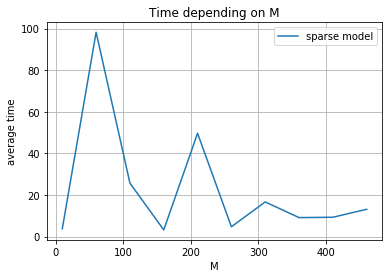

In [18]:
plt.plot(range_M, times_vary_M, label='sparse model')
plt.title('Time depending on M')
plt.ylabel('average time')
plt.xlabel('M')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# not very informative...